<a href="https://colab.research.google.com/github/sheethalkaran/FitPulse-Health-Anomaly-Detection-from-Fitness-Devices/blob/main/Milestone1/Milestone1_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)


In [13]:
hr = pd.read_csv("/content/heartrate_seconds_merged.csv")
steps = pd.read_csv("/content/minuteStepsNarrow_merged.csv")
sleep = pd.read_csv("/content/sleepDay_merged.csv")

In [14]:
print(hr.head())

           Id                  Time  Value
0  2022484408  4/12/2016 7:21:00 AM     97
1  2022484408  4/12/2016 7:21:05 AM    102
2  2022484408  4/12/2016 7:21:10 AM    105
3  2022484408  4/12/2016 7:21:20 AM    103
4  2022484408  4/12/2016 7:21:25 AM    101


In [15]:
print(steps.head())

           Id         ActivityMinute  Steps
0  1503960366  4/12/2016 12:00:00 AM      0
1  1503960366  4/12/2016 12:01:00 AM      0
2  1503960366  4/12/2016 12:02:00 AM      0
3  1503960366  4/12/2016 12:03:00 AM      0
4  1503960366  4/12/2016 12:04:00 AM      0


In [16]:
print(sleep.head())

           Id               SleepDay  TotalSleepRecords  TotalMinutesAsleep  \
0  1503960366  4/12/2016 12:00:00 AM                  1                 327   
1  1503960366  4/13/2016 12:00:00 AM                  2                 384   
2  1503960366  4/15/2016 12:00:00 AM                  1                 412   
3  1503960366  4/16/2016 12:00:00 AM                  2                 340   
4  1503960366  4/17/2016 12:00:00 AM                  1                 700   

   TotalTimeInBed  
0             346  
1             407  
2             442  
3             367  
4             712  


In [19]:
hr['DateTime'] = pd.to_datetime(hr['Time'], utc=True)
steps['DateTime'] = pd.to_datetime(
    steps['ActivityMinute'],
    format='%m/%d/%Y %I:%M:%S %p',
    utc=True
)
sleep['SleepDate'] = (
    pd.to_datetime(
        sleep['SleepDay'],
        format='%m/%d/%Y %I:%M:%S %p',
        utc=True
    )
    .dt.normalize()
)

In [22]:
print("Converted Timestamps:")
print(hr[['Time','DateTime']].head())

Converted Timestamps:
                   Time                  DateTime
0  4/12/2016 7:21:00 AM 2016-04-12 07:21:00+00:00
1  4/12/2016 7:21:05 AM 2016-04-12 07:21:05+00:00
2  4/12/2016 7:21:10 AM 2016-04-12 07:21:10+00:00
3  4/12/2016 7:21:20 AM 2016-04-12 07:21:20+00:00
4  4/12/2016 7:21:25 AM 2016-04-12 07:21:25+00:00


In [23]:
print(steps[['ActivityMinute','DateTime']].head())

          ActivityMinute                  DateTime
0  4/12/2016 12:00:00 AM 2016-04-12 00:00:00+00:00
1  4/12/2016 12:01:00 AM 2016-04-12 00:01:00+00:00
2  4/12/2016 12:02:00 AM 2016-04-12 00:02:00+00:00
3  4/12/2016 12:03:00 AM 2016-04-12 00:03:00+00:00
4  4/12/2016 12:04:00 AM 2016-04-12 00:04:00+00:00


In [24]:
print(sleep[['SleepDay','SleepDate']].head())

                SleepDay                 SleepDate
0  4/12/2016 12:00:00 AM 2016-04-12 00:00:00+00:00
1  4/13/2016 12:00:00 AM 2016-04-13 00:00:00+00:00
2  4/15/2016 12:00:00 AM 2016-04-15 00:00:00+00:00
3  4/16/2016 12:00:00 AM 2016-04-16 00:00:00+00:00
4  4/17/2016 12:00:00 AM 2016-04-17 00:00:00+00:00


In [32]:
hr_clean = (
    hr
    .set_index('DateTime')
    .groupby('Id')['Value']
    .resample('1min')
    .mean()
    .ffill()
    .reset_index()
    .rename(columns={'Value': 'HeartRate'})
)

print("Heart Rate (1-Minute, per user):")
print(hr_clean.head())

Heart Rate (1-Minute, per user):
           Id                  DateTime   HeartRate
0  2022484408 2016-04-12 07:21:00+00:00  101.600000
1  2022484408 2016-04-12 07:22:00+00:00   87.888889
2  2022484408 2016-04-12 07:23:00+00:00   58.000000
3  2022484408 2016-04-12 07:24:00+00:00   58.000000
4  2022484408 2016-04-12 07:25:00+00:00   56.777778


In [33]:
steps_clean = (
    steps
    .set_index('DateTime')
    .groupby('Id')['Steps']
    .resample('1min')
    .sum()
    .fillna(0)
    .reset_index()
)

print("Steps (1-Minute, per user):")
print(steps_clean.head())

Steps (1-Minute, per user):
           Id                  DateTime  Steps
0  1503960366 2016-04-12 00:00:00+00:00      0
1  1503960366 2016-04-12 00:01:00+00:00      0
2  1503960366 2016-04-12 00:02:00+00:00      0
3  1503960366 2016-04-12 00:03:00+00:00      0
4  1503960366 2016-04-12 00:04:00+00:00      0


In [34]:
final_df = pd.merge(
    hr_clean,
    steps_clean,
    on=['Id', 'DateTime'],
    how='inner'
).sort_values(['Id', 'DateTime'])

print("Merged HR & Steps:")
print(final_df.head())

Merged HR & Steps:
           Id                  DateTime   HeartRate  Steps
0  2022484408 2016-04-12 07:21:00+00:00  101.600000     17
1  2022484408 2016-04-12 07:22:00+00:00   87.888889      9
2  2022484408 2016-04-12 07:23:00+00:00   58.000000      0
3  2022484408 2016-04-12 07:24:00+00:00   58.000000      0
4  2022484408 2016-04-12 07:25:00+00:00   56.777778      0


In [35]:
sleep_clean = sleep[['Id', 'SleepDate', 'TotalMinutesAsleep']]
print("Sleep Data:")
print(sleep_clean.head())

Sleep Data:
           Id                 SleepDate  TotalMinutesAsleep
0  1503960366 2016-04-12 00:00:00+00:00                 327
1  1503960366 2016-04-13 00:00:00+00:00                 384
2  1503960366 2016-04-15 00:00:00+00:00                 412
3  1503960366 2016-04-16 00:00:00+00:00                 340
4  1503960366 2016-04-17 00:00:00+00:00                 700


In [36]:
final_df['Date'] = final_df['DateTime'].dt.normalize()

final_df = pd.merge(
    final_df,
    sleep_clean,
    left_on=['Id', 'Date'],
    right_on=['Id', 'SleepDate'],
    how='left'
)

final_df = final_df.drop(columns=['Date', 'SleepDate'])
final_df = final_df.set_index('DateTime')

print("Final Dataset:")
print(final_df.head())

Final Dataset:
                                   Id   HeartRate  Steps  TotalMinutesAsleep
DateTime                                                                    
2016-04-12 07:21:00+00:00  2022484408  101.600000     17                 NaN
2016-04-12 07:22:00+00:00  2022484408   87.888889      9                 NaN
2016-04-12 07:23:00+00:00  2022484408   58.000000      0                 NaN
2016-04-12 07:24:00+00:00  2022484408   58.000000      0                 NaN
2016-04-12 07:25:00+00:00  2022484408   56.777778      0                 NaN


In [38]:
final_df.to_csv('/content/drive/MyDrive/clean_fitness_data.csv')
print("Clean dataset saved to Google Drive.")

Clean dataset saved to Google Drive.


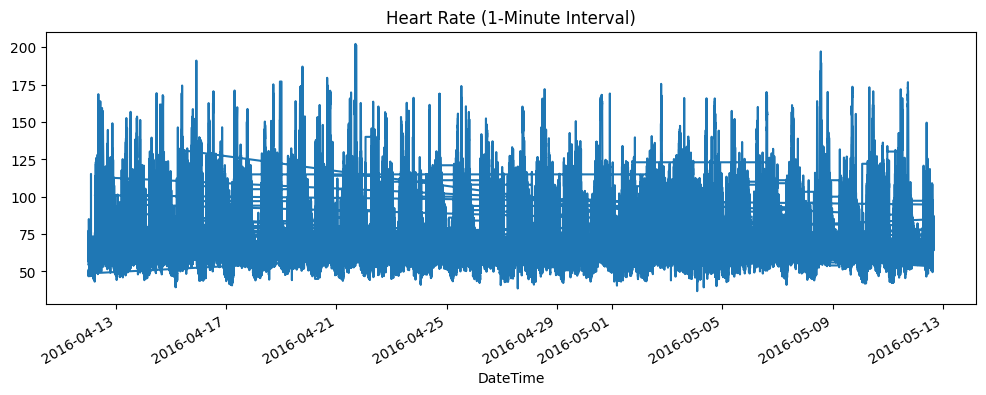

In [39]:
final_df['HeartRate'].plot(figsize=(12,4))
plt.title("Heart Rate (1-Minute Interval)")
plt.show()

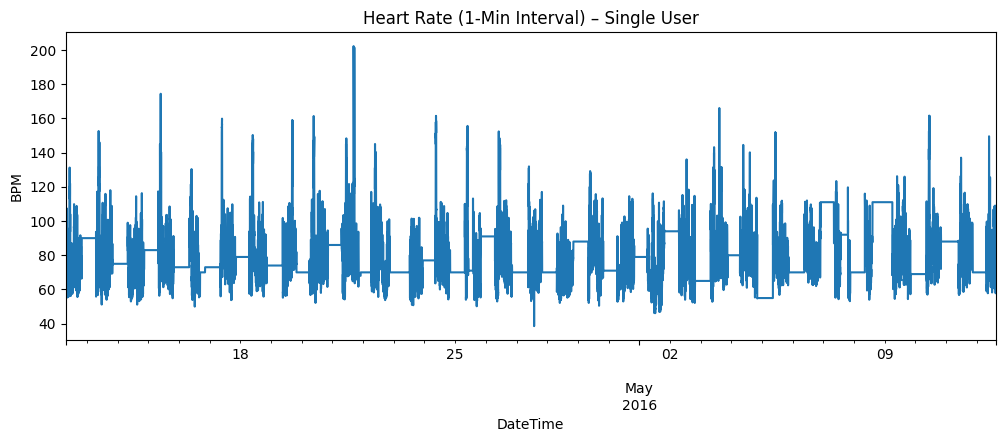

In [40]:
one_user = final_df[final_df['Id'] == 2022484408]

one_user['HeartRate'].plot(figsize=(12,4))
plt.title('Heart Rate (1-Min Interval) – Single User')
plt.xlabel('DateTime')
plt.ylabel('BPM')
plt.show()